# Imports

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import (resnet18, ResNet18_Weights, resnet50, ResNet50_Weights, resnet152, ResNet152_Weights,
                              efficientnet_b0, EfficientNet_B0_Weights,
                              vgg16, VGG16_Weights)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import time
import random
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
#torch.cuda.manual_seed_all(RANDOM_SEED)

# Configs

In [ ]:
TRAIN_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/train'
TEST_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/test'
SAVE_MODEL_DIR = '/content/drive/MyDrive/GBCUD/'

In [ ]:
RANDOM_SEED = 42
LABEL_MAPPING = {'0_normal': 0, '1_benign': 1, '2_malignant': 2}
CLASS_NAMES = list(LABEL_MAPPING.keys())

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1      # for bag-level processing
NUM_EPOCHS = 50
PATIENCE = 10
BAG_SIZE = 10       # Fixed number of instances per bag
NUM_CLASSES = len(LABEL_MAPPING)
CLASS_WEIGHTS = [0.8, 0.6, 3.0] # Example weights

FEATURE_DIM_L = 512
ATTENTION_DIM_D = 256
ATTENTION_HEADS_K = 1
DROPOUT_RATE = 0.5

IMG_RESIZE = (256, 256) # Initial resize size
IMG_CROP_SIZE = (224, 224) # Final input size to model (and patch size if not using separate patches)
PATCH_SIZE = (128, 128) # Size of patches to extract
PATCH_STRIDE = 64       # Stride for patch extraction

# Define normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Helper functions

In [ ]:
#plots training and validation loss and accuracy graphs
def plot_training_history(train_losses, train_acc, val_losses, val_acc):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Model Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#compute and plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Preprocessing and Data augmentation

In [ ]:
 # applies transforms to the entire image before patching
def get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE):
  def crop_bottom_half(image, **kwargs):
      h, w = image.shape[:2]
      y_min = int(0.25 * h)
      y_max = int(0.90 * h)
      return image[y_min:y_max, :]

  return A.Compose([
      A.Resize(height=resize_dim[0], width=resize_dim[1]),
      A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, fill=0),
      A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
      # A.ISONoise(intensity=(0.1, 0.4), p=0.3),
      # A.RandomShadow(p=0.3),
      A.Lambda(image=crop_bottom_half),
      # A.CenterCrop(height=crop_dim[0], width=crop_dim[1]),
      A.HorizontalFlip(p=0.5),
      A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ToTensorV2()
  ])

def get_eval_transforms(img_dim=IMG_CROP_SIZE):
    return A.Compose([
        A.Resize(height=img_dim[0], width=img_dim[1]),
        A.CenterCrop(height=img_dim[0], width=img_dim[1]),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

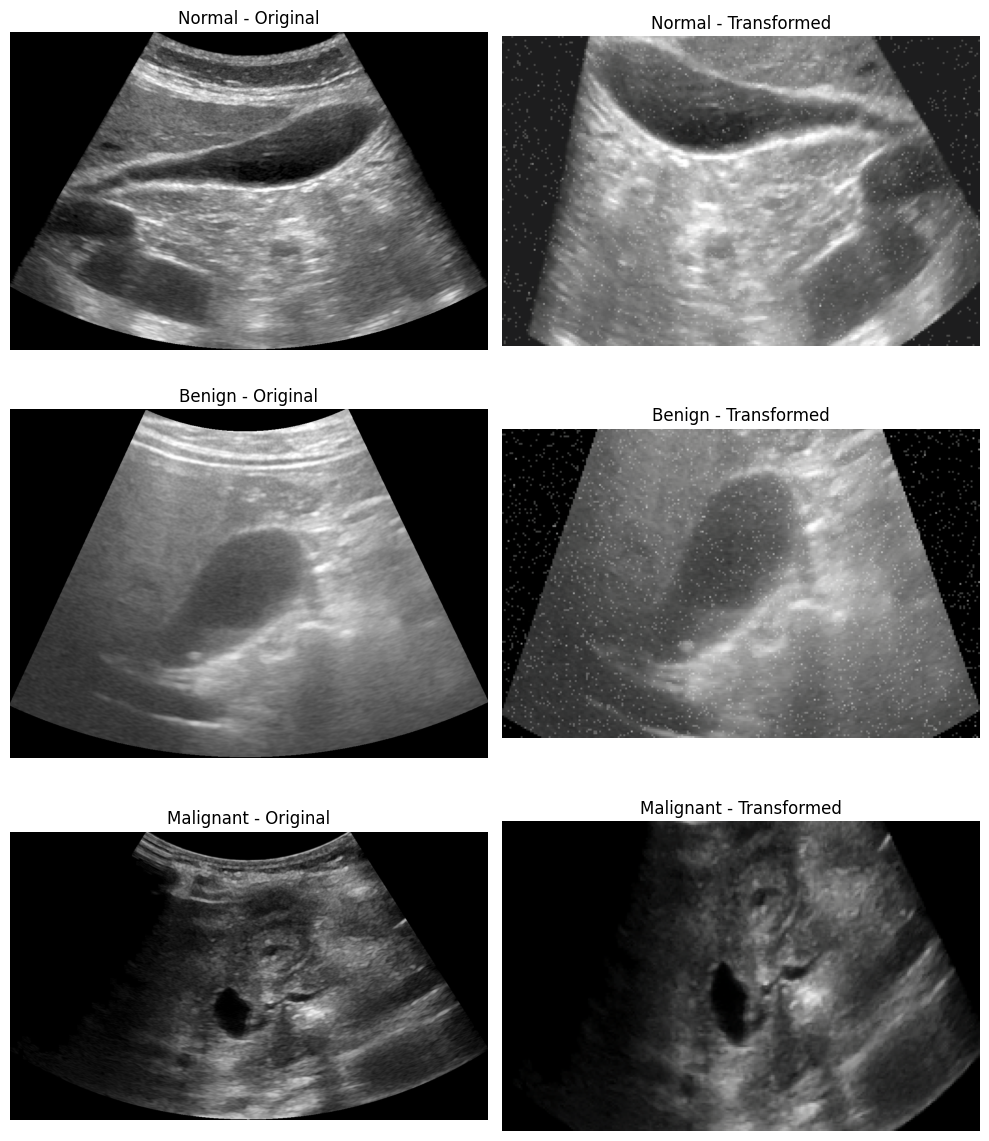

In [ ]:
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.transforms.functional import to_pil_image
import numpy as np


# Load and transform image
def visualize_transformed_image(image_path, transform):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    transformed = transform(image=original_img)
    transformed_img = transformed["image"]

    # De-normalize for visualization
    img_vis = transformed_img.clone()
    img_vis = img_vis * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_vis = img_vis + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img_vis = torch.clamp(img_vis, 0, 1)

    return original_img, to_pil_image(img_vis)

# Example usage:
sample_paths = {
    "Normal": "/content/drive/MyDrive/GBCUD/dataset/train/0_normal/im00007.jpg",
    "Benign": "/content/drive/MyDrive/GBCUD/dataset/train/1_benign/im00001.jpg",
    "Malignant": "/content/drive/MyDrive/GBCUD/dataset/train/2_malignant/im00017.jpg"
}

transform = get_train_transforms()

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for idx, (label, img_path) in enumerate(sample_paths.items()):
    original, transformed = visualize_transformed_image(img_path, transform)

    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title(f"{label} - Original")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(transformed)
    axes[idx, 1].set_title(f"{label} - Transformed")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


# Dataset

In [ ]:
class ImageToPatchesDataset(Dataset):
  def __init__(self, image_dir, label_mapping, transform=None,
                patch_size_wh=PATCH_SIZE, stride=PATCH_STRIDE, bag_size=BAG_SIZE):
    self.image_paths = []
    self.labels = []
    self.transform = transform
    self.patch_h, self.patch_w = patch_size_wh
    self.stride = stride
    self.bag_size = bag_size

    for class_name, class_idx in label_mapping.items():
      class_folder = os.path.join(image_dir, class_name)

      for filename in os.listdir(class_folder):
        if filename.lower().endswith((".jpg", ".jpeg")):
          self.image_paths.append(os.path.join(class_folder, filename))
          self.labels.append(class_idx)

    self.targets = self.labels

  def __len__(self):
    return len(self.image_paths)

  def extract_patches(self, img_tensor):
    # image tensor shape
    C, H, W = img_tensor.shape
    patches = []

    if H < self.patch_h or W < self.patch_w:
      resized_patch = TF.resize(img_tensor, (self.patch_h, self.patch_w), antialias=True)
      patches.append(resized_patch)
    else:
      # extract patches using sliding window
      for i in range(0, H - self.patch_h + 1, self.stride):
        for j in range(0, W - self.patch_w + 1, self.stride):
          patch = img_tensor[:, i:i + self.patch_h, j:j + self.patch_w]
          patches.append(patch)

    # Shape: [num_patches, C, H_patch, W_patch]
    return torch.stack(patches)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label = self.labels[idx]

    img = Image.open(img_path).convert('RGB')

    # apply augmentations for the full image
    transformed = self.transform(image=np.array(img))
    img_tensor = transformed['image']

    #extract patches
    patches = self.extract_patches(img_tensor)
    num_patches = patches.shape[0]

    if num_patches >= self.bag_size:
      indices = np.random.choice(num_patches, self.bag_size, replace=False)
    else:
      indices = np.random.choice(num_patches, self.bag_size, replace=True)

    bag = patches[indices]
    # label = torch.tensor(label)

    return bag, label

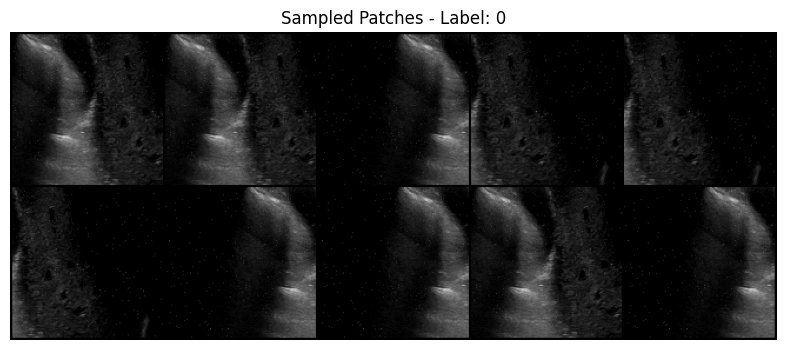

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def visualize_patches(dataset, idx, nrow=5, title=None):
    """
    Displays sampled patches from the MIL bag for the image at `idx`.

    Args:
        dataset: an instance of your MIL dataset
        idx (int): index of the image to visualize
        nrow (int): number of patches per row in the grid
        title (str): optional title for the plot
    """
    bag_tensor, label = dataset[idx]

    # Make sure tensor is on CPU and within [0,1] for display
    bag_tensor_vis = bag_tensor.clone().detach().cpu()
    bag_tensor_vis = (bag_tensor_vis * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                      torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1))
    bag_tensor_vis = torch.clamp(bag_tensor_vis, 0, 1)

    # Create a grid of patches
    grid = vutils.make_grid(bag_tensor_vis, nrow=nrow, padding=2)

    # Plot the grid
    plt.figure(figsize=(nrow * 2, 2 * (dataset.bag_size // nrow)))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(title or f"Sampled Patches - Label: {label}")
    plt.show()



train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)

full_train_dataset = ImageToPatchesDataset(
    image_dir=TRAIN_IMGS_PATH,
    label_mapping=LABEL_MAPPING,
    transform=train_transforms,
    patch_size_wh=PATCH_SIZE,
    stride=PATCH_STRIDE,
    bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
)
visualize_patches(full_train_dataset, idx=10, nrow=5)

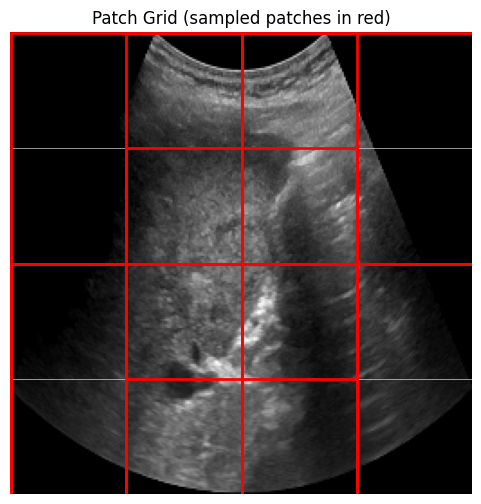

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as T
import numpy as np
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def visualize_patch_grid(image_path, transform, patch_size=(128, 128), stride=64, bag_size=10):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    transformed = transform(image=np.array(image))
    img_tensor = transformed['image']  # shape: (C, H, W)

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225])) +
                     np.array([0.485, 0.456, 0.406]), 0, 1)

    C, H, W = img_tensor.shape
    patch_h, patch_w = patch_size

    all_coords = []
    for y in range(0, H - patch_h + 1, stride):
        for x in range(0, W - patch_w + 1, stride):
            all_coords.append((x, y))

    # Randomly sample bag_size patches
    sampled_coords = (np.random.choice(len(all_coords), bag_size, replace=(len(all_coords) < bag_size)))
    sampled_coords = [all_coords[i] for i in sampled_coords]

    # Plot
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_np)
    ax.set_title("Patch Grid (sampled patches in red)")

    # All patch boxes
    for (x, y) in all_coords:
        rect = patches.Rectangle((x, y), patch_w, patch_h, linewidth=0.5, edgecolor='lightgray', facecolor='none')
        ax.add_patch(rect)

    # Sampled patch boxes
    for (x, y) in sampled_coords:
        rect = patches.Rectangle((x, y), patch_w, patch_h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()


img_path = "/content/drive/MyDrive/GBCUD/dataset/train/2_malignant/im00005.jpg" # Or use: dataset.image_paths[idx]
visualize_patch_grid(
    image_path=img_path,
    transform=get_eval_transforms(img_dim=(256, 256)),  # or your training transforms
    patch_size=(128, 128),
    stride=64,
    bag_size=10
)


# Model build

In [ ]:
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes=3, backbone_name='resnet18', pretrained=True,
                 feature_dim=512, attention_dim=128, attention_heads=1, dropout=0.25):
        super().__init__()
        self.L = feature_dim
        self.D = attention_dim
        self.K = attention_heads
        self.num_classes = num_classes

        # Backbone feature extractor
        self.feature_extractor, backbone_out_dim = self._get_backbone(backbone_name, pretrained)

        # Adaptive pooling and feature embedding
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_embedder = nn.Sequential(
            nn.Linear(backbone_out_dim, self.L),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Vanilla Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        # Classifier
        self.classifier = nn.Linear(self.L * self.K, self.num_classes)

    def _get_backbone(self, name, pretrained):
        weights = 'DEFAULT' if pretrained else None

        if name == "resnet18":
            model = resnet18(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 512
        elif name == "resnet50":
            model = resnet50(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "resnet152":
            model = resnet152(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "efficientnet_b0":
            model = efficientnet_b0(weights=weights)
            return model.features, 1280
        elif name == "vgg16":
            model = vgg16(weights=weights)
            return nn.Sequential(*list(model.features.children())[:-1]), 512
        else:
            raise ValueError(f"Unsupported backbone: {name}")

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.view(B * N, C, H, W)

        features = self.feature_extractor(x)
        features = self.pool(features).view(B * N, -1)
        embedded = self.feature_embedder(features)  # (B*N, L)

        A = self.attention(embedded)               # (B*N, K)
        A = A.view(B, N, self.K)
        A = F.softmax(A, dim=1)                    # softmax over instances

        A = A.transpose(1, 2)                      # (B, K, N)
        embedded = embedded.view(B, N, self.L)     # (B, N, L)
        M = torch.bmm(A, embedded)                 # (B, K, L)

        M = M.view(B, -1)
        logits = self.classifier(M)                # (B, num_classes)
        probs = F.softmax(logits, dim=1)

        return logits, probs, A.transpose(1, 2)

    def calculate_objective(self, x_batch, y_batch, criterion):
        logits, _, _ = self.forward(x_batch)
        return criterion(logits, y_batch)

    def calculate_prediction_accuracy(self, x_batch, y_batch):
        logits, _, _ = self.forward(x_batch)
        preds = torch.argmax(logits, dim=1)
        correct = preds.eq(y_batch).sum().item()
        total = y_batch.size(0)
        return preds, correct / total, correct, total

    def get_attention_map(self, bag_tensor):
        self.eval()
        with torch.no_grad():
            if bag_tensor.ndim != 4:
                raise ValueError(f"Expected input of shape (bag_size, 3, H, W), got {bag_tensor.shape}")

            N, C, H, W = bag_tensor.shape
            device = next(self.parameters()).device
            bag_tensor = bag_tensor.to(device)

            features = self.feature_extractor(bag_tensor)
            features = self.pool(features).view(N, -1)
            embedded = self.feature_embedder(features)

            A_scores = self.attention(embedded)      # (N, K)
            A_weights = F.softmax(A_scores, dim=0)   # softmax over instances
            attention = A_weights[:, 0].cpu().numpy()

            return attention


In [ ]:
#vanilla attention
model = AttentionMILModel(num_classes=3, backbone_name='resnet18')
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
#gated attention
model = AttentionMILModel(num_classes=3, backbone_name='resnet18')
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
dummy_input = torch.randn(1, 10, 3, 224, 224)
logits, probs, att = model(dummy_input)
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Train and Evaluate

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, save_dir, model_name, patience=PATIENCE):
  os.makedirs(save_dir, exist_ok=True)

  best_val_loss = float('inf')
  best_model_wts = None
  epochs_no_improve = 0
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


  model.to(device)
  print(f"Training started...")

  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for bags, labels in train_loader:
      bags = bags.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      logits, probs, _ = model(bags)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * bags.size(0) # Weighted by batch size
      preds = torch.argmax(probs, dim=1)
      train_correct += (preds == labels).sum().item()
      train_total += labels.size(0)

    epoch_train_loss = running_loss / train_total
    epoch_train_acc = train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # validation
    val_metrics, _, _ = evaluate_model(model, val_loader, criterion, device)
    epoch_val_loss = val_metrics['loss']
    epoch_val_acc = val_metrics['accuracy']
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # early stopping
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      epochs_no_improve = 0
      save_path = os.path.join(save_dir, model_name)
      torch.save(model.state_dict(), save_path)
      print(f"Validation loss improved. Model saved to {save_path}")
    else:
      epochs_no_improve += 1
      print(f"Validation loss did not improve for {epochs_no_improve} epochs.")
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} after {patience} epochs without improvement.")
        break

  print("\nTraining finished.")

  model.load_state_dict(torch.load(save_path))
  print("Loaded best model weights.")

  return model, history

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for bags, labels in dataloader:
            bags = bags.to(device)
            labels = labels.to(device)

            logits, probs, _ = model(bags)
            loss = criterion(logits, labels)
            total_loss += loss.item() * bags.size(0) # Multiply by batch size (num bags)

            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    # Calculate other metrics using sklearn
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    return metrics, all_labels, all_preds

# Experiments

gated attention

In [ ]:
BACKBONE_NAME = "resnet18"
PRETRAINED = "true"

In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model1.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")



Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet18 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 15.28s | Train Loss: 1.1009, Acc: 0.3521 | Val Loss: 1.1222, Acc: 0.3216
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model1.pth
Epoch 2/50 | Time: 16.73s | Train Loss: 1.0884, Acc: 0.3918 | Val Loss: 1.1606, Acc: 0.2555
Validation loss did not improve for 1 epochs.
Epoch 3/50 | Time: 15.23s | Train Loss: 1.0730, Acc: 0.4150 | Val Loss: 1.1365, Acc: 0.4009
Validation loss did not improve for 2 epochs.
Epoch 4/50 | Time: 15.35s | Train Loss: 0.9858, Acc: 0.5132 | Val Loss: 1.3244, Acc: 0.3040
Validation loss did not

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: plot_training_history() got an unexpected keyword argument 'save_path'

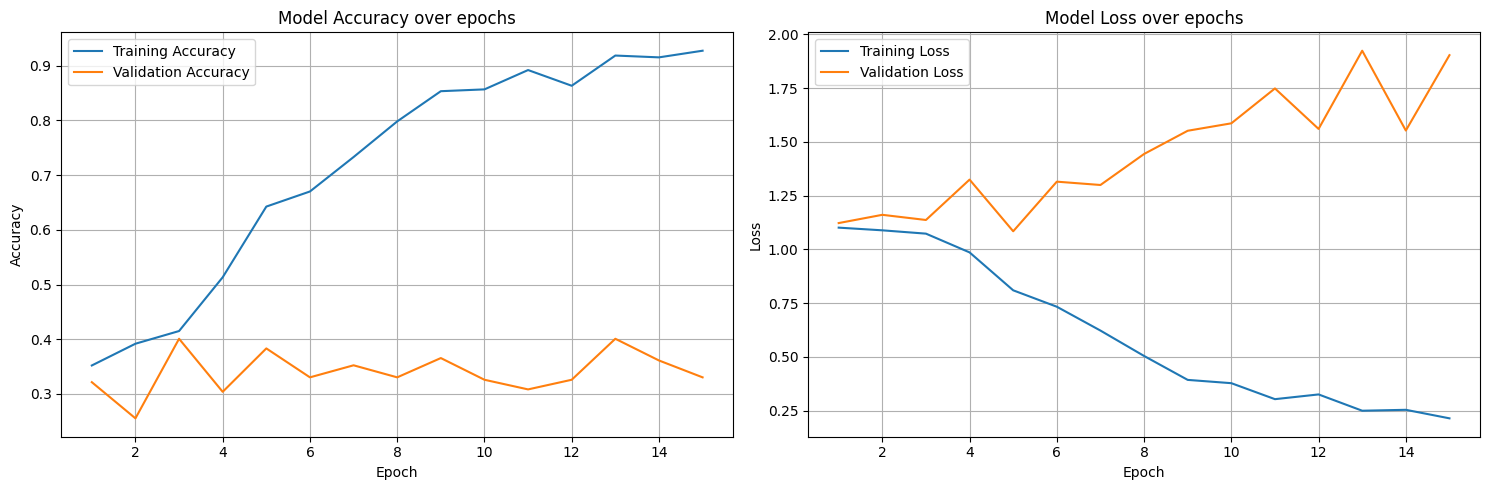

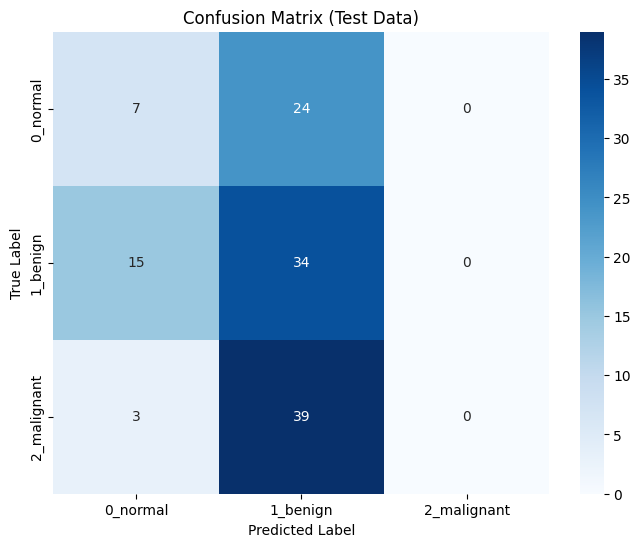

In [ ]:
plot_training_history(history['train_loss'], history['train_acc'],
                      history['val_loss'], history['val_acc'])

#Confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

In [ ]:
BACKBONE_NAME = "resnet50"
PRETRAINED = "true"

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet18 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 16.40s | Train Loss: 1.1008, Acc: 0.3742 | Val Loss: 1.1471, Acc: 0.2423
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 16.12s | Train Loss: 1.0878, Acc: 0.3885 | Val Loss: 1.0896, Acc: 0.3656
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 3/50 | Time: 17.77s | Train Loss: 1.0672, Acc: 0.4327 | Val Loss: 1.0953, Acc: 0.3744
Validation loss did not improve for 1 epochs.
Epoch 4/50 | Time: 16.11s | Train Loss: 0.9886, Acc: 0.5143 | Val Loss: 1.07

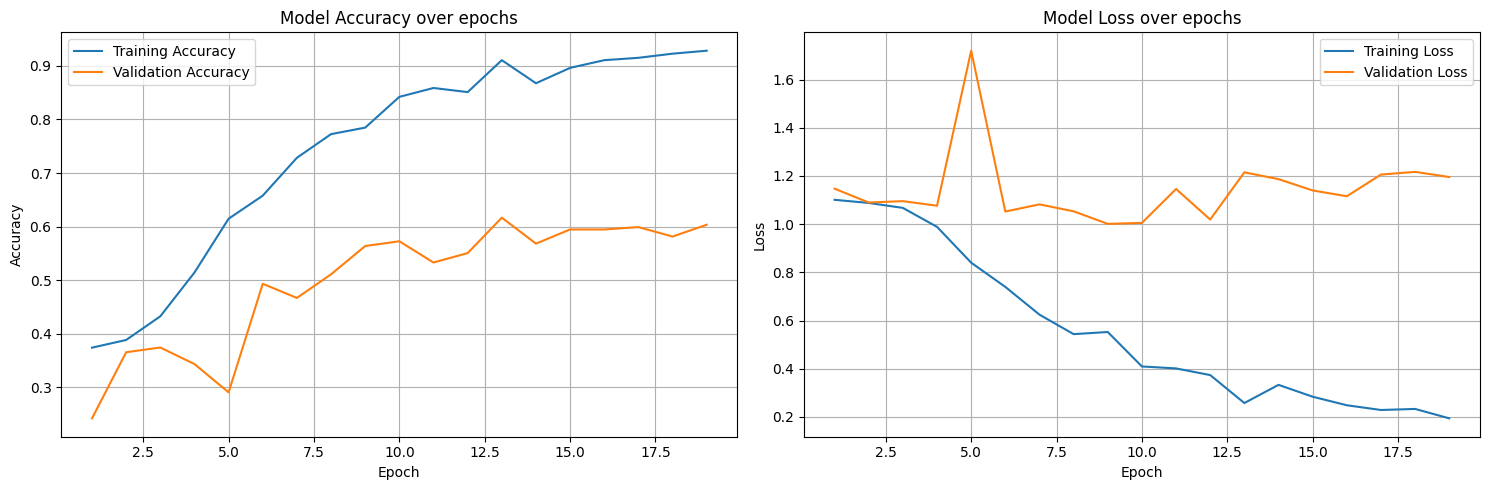

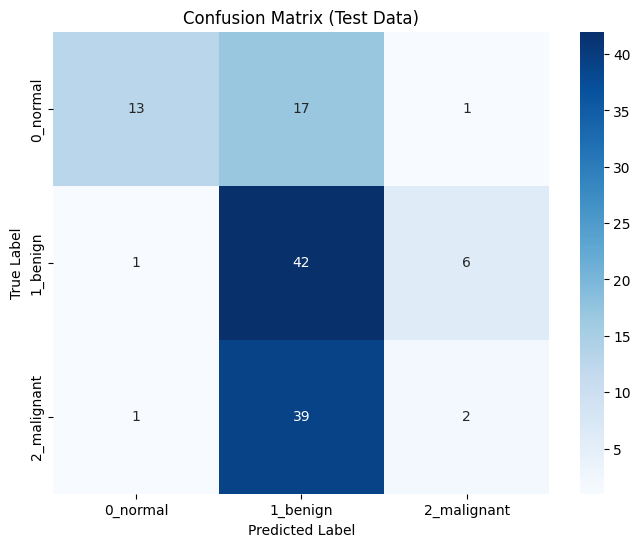


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet50"
PRETRAINED = "true"

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet50 backbone


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 31.43s | Train Loss: 1.0966, Acc: 0.3455 | Val Loss: 1.0992, Acc: 0.2731
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 32.04s | Train Loss: 1.0860, Acc: 0.3985 | Val Loss: 1.1008, Acc: 0.2775
Validation loss did not improve for 1 epochs.
Epoch 3/50 | Time: 29.91s | Train Loss: 1.0498, Acc: 0.4746 | Val Loss: 1.5628, Acc: 0.2159
Validation loss did not improve for 2 epochs.
Epoch 4/50 | Time: 30.11s | Train Loss: 0.8706, Acc: 0.5751 | Val Loss: 0.9664, Acc: 0.4934
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 5/50 | Time: 31.77s | Train Loss: 0.7423, Acc: 0.6667 | Val Loss: 0.9586, Acc: 0.5639
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 6/50 | Time: 32.09s | Train Loss: 0.6565, Acc: 0.7208 | Val Loss: 0.8835, Acc: 0.5639
Validation loss improved. Mo

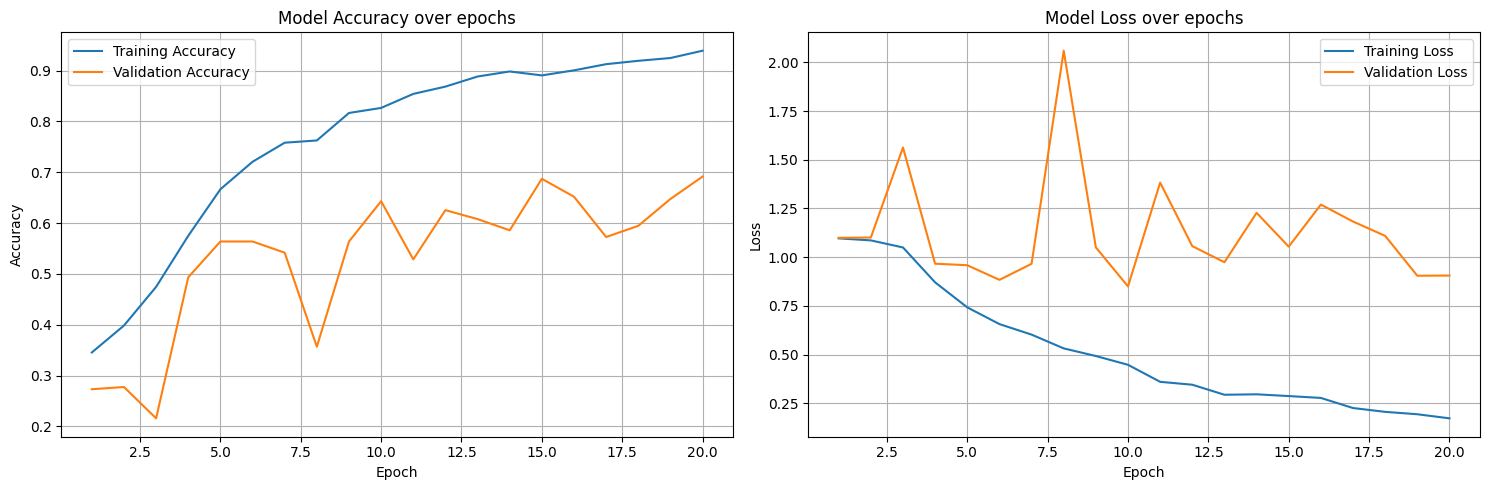

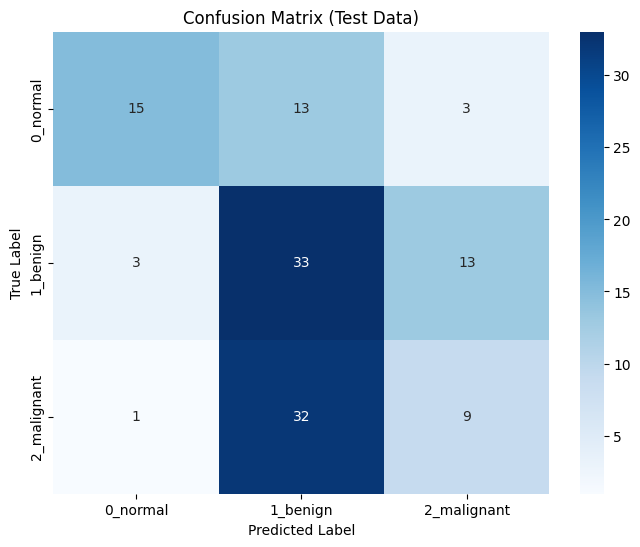


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

vanilla attention

In [ ]:
BACKBONE_NAME = "resnet50"
PRETRAINED = "true"

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet50 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 32.29s | Train Loss: 1.0980, Acc: 0.3521 | Val Loss: 1.1028, Acc: 0.1938
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 33.60s | Train Loss: 1.0948, Acc: 0.3466 | Val Loss: 1.0974, Acc: 0.3656
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 3/50 | Time: 33.18s | Train Loss: 1.0781, Acc: 0.4194 | Val Loss: 1.0997, Acc: 0.3744
Validation loss did not improve for 1 epochs.
Epoch 4/50 | Time: 31.19s | Train Loss: 0.9989, Acc: 0.4956 | Val Loss: 1.05

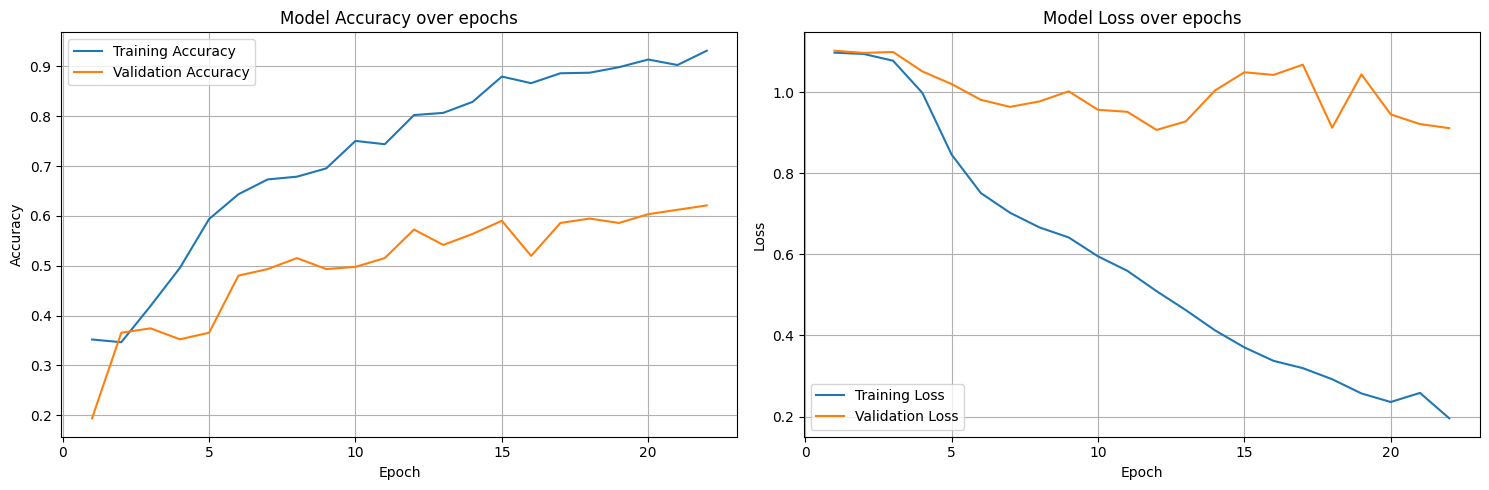

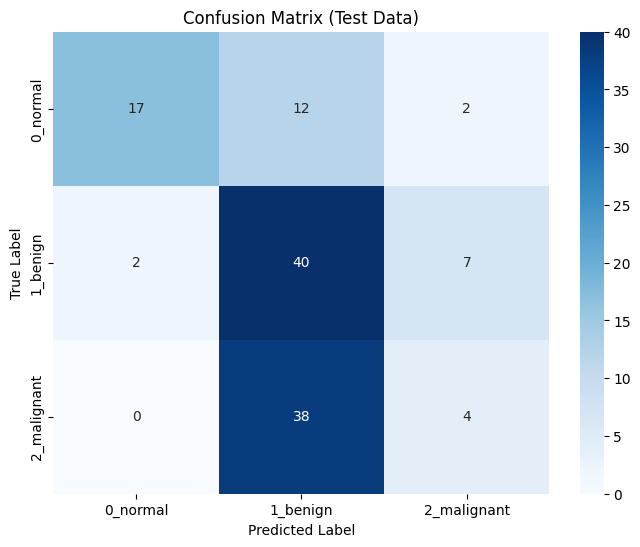


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet18"
PRETRAINED = "true"

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet18 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 16.33s | Train Loss: 1.0973, Acc: 0.3466 | Val Loss: 1.0852, Acc: 0.4449
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 17.19s | Train Loss: 1.0959, Acc: 0.3598 | Val Loss: 1.1279, Acc: 0.3084
Validation loss did not improve for 1 epochs.
Epoch 3/50 | Time: 16.25s | Train Loss: 1.0863, Acc: 0.4172 | Val Loss: 1.1143, Acc: 0.3568
Validation loss did not improve for 2 epochs.
Epoch 4/50 | Time: 15.76s | Train Loss: 1.0536, Acc: 0.4879 | Val Loss: 1.0819, Acc: 0.4053
Validation loss improve

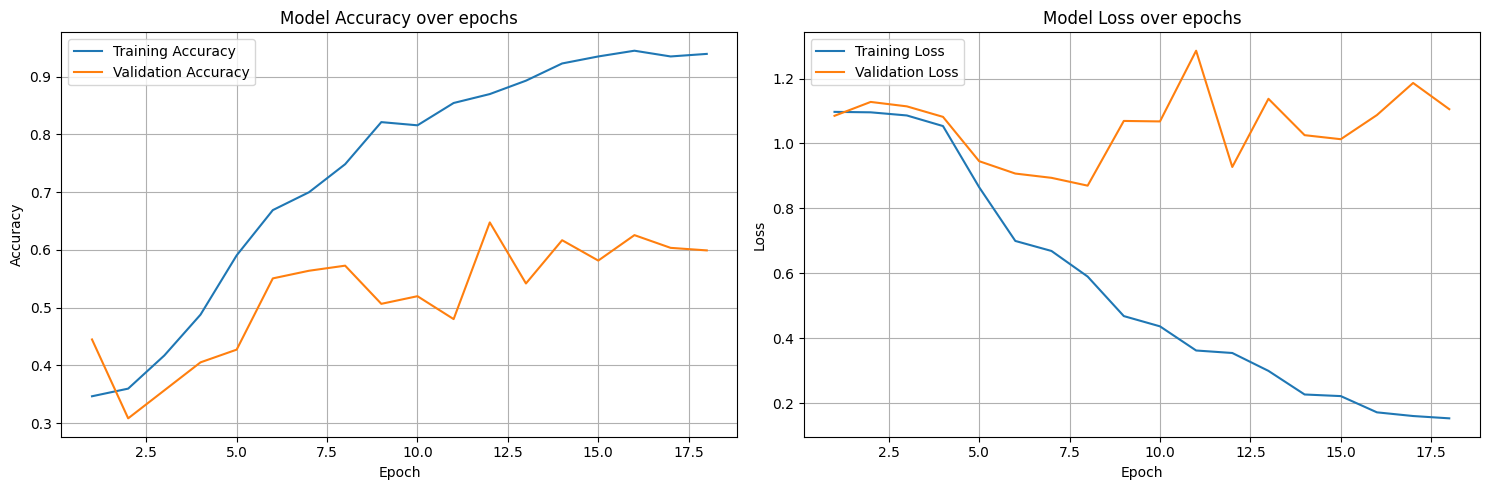

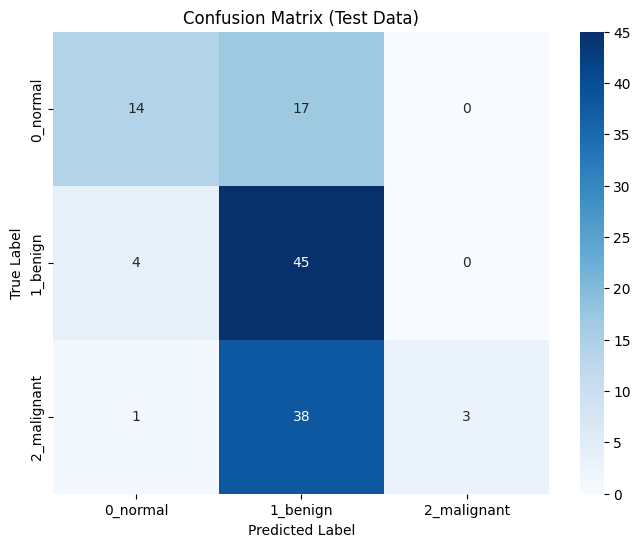


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "efficientnet_b0"
PRETRAINED = "true"

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with efficientnet_b0 backbone


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]

Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...


Epoch 1/50 | Time: 42.29s | Train Loss: 1.0998, Acc: 0.3587 | Val Loss: 1.0918, Acc: 0.3612
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 41.07s | Train Loss: 1.0959, Acc: 0.3642 | Val Loss: 1.1082, Acc: 0.3524
Validation loss did not improve for 1 epochs.
Epoch 3/50 | Time: 40.33s | Train Loss: 1.0996, Acc: 0.3488 | Val Loss: 1.1035, Acc: 0.3216
Validation loss did not improve for 2 epochs.
Epoch 4/50 | Time: 39.98s | Train Loss: 1.0965, Acc: 0.3709 | Val Loss: 1.1123, Acc: 0.1982
Validation loss did not improve for 3 epochs.
Epoch 5/50 | Time: 40.24s | Train Loss: 1.0955, Acc: 0.3642 | Val Loss: 1.1156, Acc: 0.1982
Validation loss did not improve for 4 epochs.
Epoch 6/50 | Time: 39.94s | Train Loss: 1.0967, Acc: 0.3455 | Val Loss: 1.1066, Acc: 0.2070
Validation loss did not improve for 5 epochs.
Epoch 7/50 | Time: 40.32s | Train Loss: 1.0942, Acc: 0.3653 | Val Loss: 1.0875, Acc: 0.4581
Validation loss improved. Model saved to 

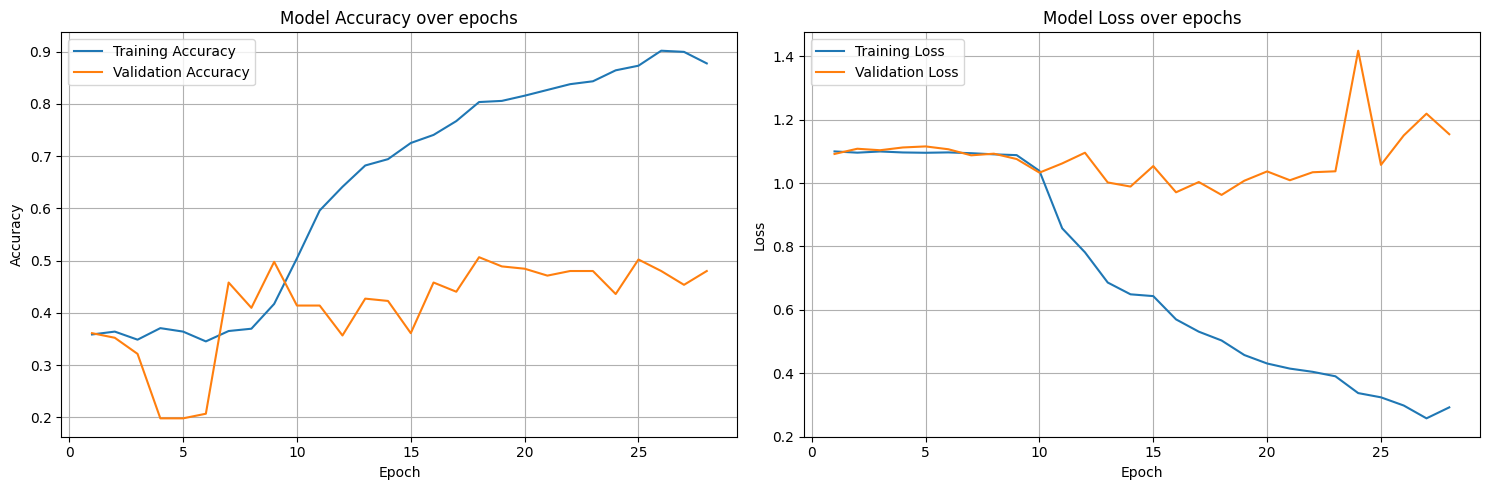

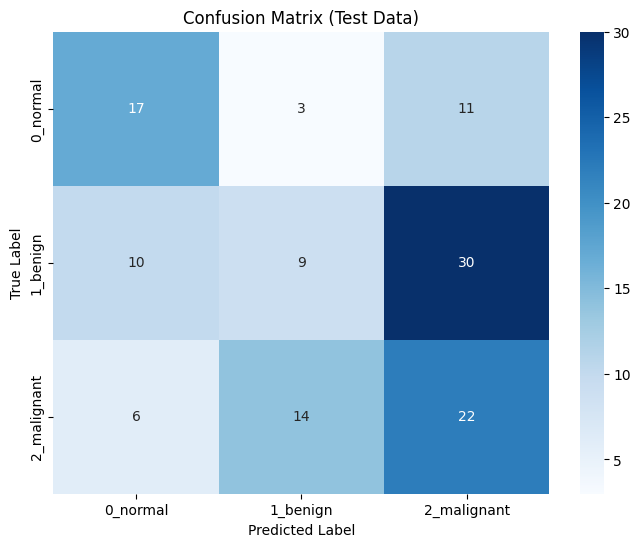


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet18"
PRETRAINED = "true"

In [ ]:
BAG_SIZE=10
PATCH_STRIDE = 48

Using device: cuda
Batch size (bags): 1
Patches per bag: 10
Patch size: (128, 128)
Load the datasets...
Full Train dataset: 1133 bags found.
Test dataset: 122 bags found.
Classes: ['0_normal', '1_benign', '2_malignant']
Splitting train data
Training subset size: 906
Validation subset size: 227
Creating DataLoaders...
Setting up model with resnet18 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Time: 17.04s | Train Loss: 1.1010, Acc: 0.3444 | Val Loss: 1.0965, Acc: 0.3348
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Time: 18.13s | Train Loss: 1.0965, Acc: 0.3598 | Val Loss: 1.0964, Acc: 0.3304
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 3/50 | Time: 17.97s | Train Loss: 1.0603, Acc: 0.4525 | Val Loss: 1.9636, Acc: 0.2115
Validation loss did not improve for 1 epochs.
Epoch 4/50 | Time: 16.14s | Train Loss: 0.9046, Acc: 0.5751 | Val Loss: 1.08

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


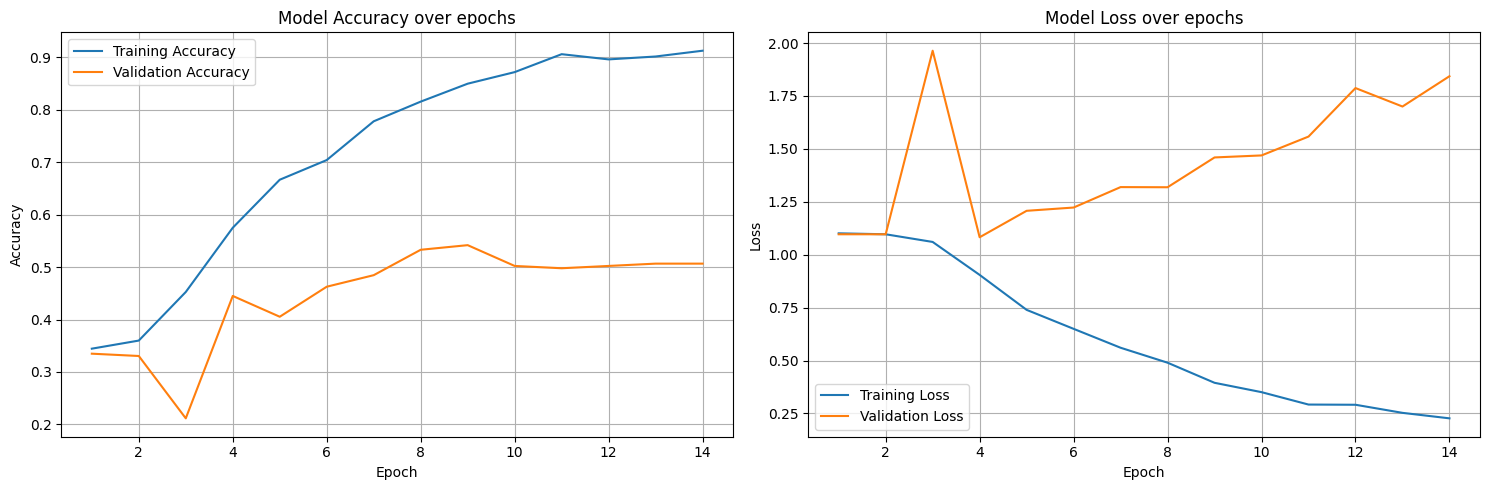

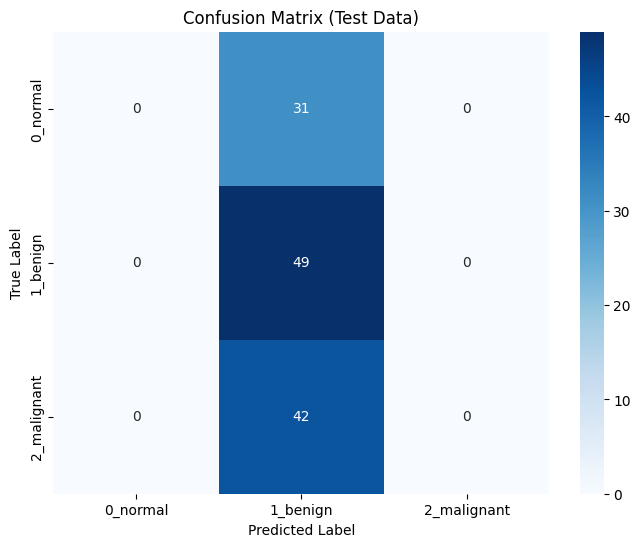


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Batch size (bags): {BATCH_SIZE}")
    print(f"Patches per bag: {BAG_SIZE}")
    print(f"Patch size: {PATCH_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")
    full_train_dataset = ImageToPatchesDataset(
        image_dir=TRAIN_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=train_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE # Pass bag size to dataset for sampling/padding
    )

    test_dataset = ImageToPatchesDataset(
        image_dir=TEST_IMGS_PATH,
        label_mapping=LABEL_MAPPING,
        transform=eval_transforms,
        patch_size_wh=PATCH_SIZE,
        stride=PATCH_STRIDE,
        bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")
    print(f"Classes: {CLASS_NAMES}")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")